## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.3, 0.1]
redice_lr_patient = [5, 3 , 2]

In [12]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 2s 37us/step - loss: 1.4283 - accuracy: 0.5005 - val_loss: 1.5573 - val_accuracy: 0.4529
Epoch 11/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4063 - accuracy: 0.5092 - val_loss: 1.5463 - val_accuracy: 0.4545
Epoch 12/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3833 - accuracy: 0.5182 - val_loss: 1.5435 - val_accuracy: 0.4552
Epoch 13/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3615 - accuracy: 0.5263 - val_loss: 1.5325 - val_accuracy: 0.4591
Epoch 14/25
50000/50000 [==============================] - 2s 34us/step - loss: 1.3434 - accuracy: 0.5334 - val_loss: 1.5222 - val_accuracy: 0.4616
Epoch 15/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3241 - accuracy: 0.5404 - val_loss: 1.5162 - val_accuracy: 0.4687
Epoch 16/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.3054 - accuracy: 0.5462 - val_loss: 1.5083

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 49us/step - loss: 2.3669 - accuracy: 0.2313 - val_loss: 2.1666 - val_accuracy: 0.1943
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.8700 - accuracy: 0.3552 - val_loss: 2.0356 - val_accuracy: 0.2673
Epoch 3/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.7336 - accuracy: 0.3988 - val_loss: 1.9001 - val_accuracy: 0.3343
Epoch 4/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6595 - accuracy: 0.4233 - val_loss: 1.7957 - val_accuracy: 0.3756
Epoch 5/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.6081 - accuracy: 0.4391 - val_loss: 1.7146 - val_accuracy: 0.4042
Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5651 - accuracy: 0.4550 - val_loss: 1.6662 - val_accuracy: 0.4163
Epoch 7/25
50000/50000 [==============================] - 2s 36us/st

Epoch 21/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1951 - accuracy: 0.5906 - val_loss: 1.4908 - val_accuracy: 0.4844
Epoch 22/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1815 - accuracy: 0.5961 - val_loss: 1.4819 - val_accuracy: 0.4779
Epoch 23/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1658 - accuracy: 0.6026 - val_loss: 1.4786 - val_accuracy: 0.4882
Epoch 24/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1509 - accuracy: 0.6082 - val_loss: 1.4732 - val_accuracy: 0.4836
Epoch 25/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.1354 - accuracy: 0.6133 - val_loss: 1.4693 - val_accuracy: 0.4878
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 2
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)            

Epoch 6/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5511 - accuracy: 0.4585 - val_loss: 1.6770 - val_accuracy: 0.4088
Epoch 7/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.5161 - accuracy: 0.4726 - val_loss: 1.6472 - val_accuracy: 0.4190
Epoch 8/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4844 - accuracy: 0.4841 - val_loss: 1.6117 - val_accuracy: 0.4316
Epoch 9/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4560 - accuracy: 0.4929 - val_loss: 1.5886 - val_accuracy: 0.4414
Epoch 10/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4310 - accuracy: 0.5018 - val_loss: 1.5738 - val_accuracy: 0.4433
Epoch 11/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.4073 - accuracy: 0.5117 - val_loss: 1.5628 - val_accuracy: 0.4501
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3842 - accuracy: 0.5196 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 50us/step - loss: 2.3470 - accuracy: 0.2361 - val_loss: 2.1389 - val_accuracy: 0.2274
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.8575 - accuracy: 0.3575 - val_loss: 2.0085 - val_accuracy: 0.2789
Epoch 3/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.7173 - accuracy: 0.4036 - val_loss: 1.8942 - val_accuracy: 0.3306
Epoch 4/25
50000/50000 [==============================] - 2s 35us/step - loss: 1.6407 - accuracy: 0.4273 - val_loss: 1.7816 - val_accuracy: 0.3742
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5864 - accuracy: 0.4472 - val_loss: 1.7118 - val_accuracy: 0.3981
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5435 - accuracy: 0.4625 - val_loss: 1.6547 - val_accuracy: 0.4146
Epoch 7/25
50000/50000 [==============================] - 2s 38us/st

50000/50000 [==============================] - 2s 39us/step - loss: 0.5976 - accuracy: 0.7993 - val_loss: 1.6953 - val_accuracy: 0.4636

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 21/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.5046 - accuracy: 0.8422 - val_loss: 1.4963 - val_accuracy: 0.5241
Epoch 22/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.4660 - accuracy: 0.8595 - val_loss: 1.5559 - val_accuracy: 0.5184
Epoch 23/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.4449 - accuracy: 0.8672 - val_loss: 1.5529 - val_accuracy: 0.5134
Epoch 24/25
50000/50000 [==============================] - 2s 41us/step - loss: 0.4248 - accuracy: 0.8743 - val_loss: 1.6651 - val_accuracy: 0.5013
Epoch 25/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.4022 - accuracy: 0.8834 - val_loss: 1.6440 - val_accuracy: 0.5088
Numbers of exp: 10, reduce_factor: 0.50, re

50000/50000 [==============================] - 2s 37us/step - loss: 1.7045 - accuracy: 0.4079 - val_loss: 1.9559 - val_accuracy: 0.3406
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6080 - accuracy: 0.4412 - val_loss: 1.8345 - val_accuracy: 0.3695
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5478 - accuracy: 0.4601 - val_loss: 1.7261 - val_accuracy: 0.4113
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5028 - accuracy: 0.4779 - val_loss: 1.6514 - val_accuracy: 0.4309
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4660 - accuracy: 0.4884 - val_loss: 1.6040 - val_accuracy: 0.4409
Epoch 7/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4345 - accuracy: 0.5016 - val_loss: 1.5691 - val_accuracy: 0.4535
Epoch 8/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4068 - accuracy: 0.5106 - val_loss: 1.5549 - val

Epoch 22/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3429 - accuracy: 0.5378 - val_loss: 1.5542 - val_accuracy: 0.4577
Epoch 23/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3331 - accuracy: 0.5424 - val_loss: 1.5525 - val_accuracy: 0.4595
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3236 - accuracy: 0.5445 - val_loss: 1.5516 - val_accuracy: 0.4594
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3139 - accuracy: 0.5488 - val_loss: 1.5485 - val_accuracy: 0.4584
Numbers of exp: 13, reduce_factor: 0.30, reduce_patient: 3
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_

Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5767 - accuracy: 0.4509 - val_loss: 1.6703 - val_accuracy: 0.4076
Epoch 8/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5518 - accuracy: 0.4590 - val_loss: 1.6521 - val_accuracy: 0.4155
Epoch 9/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5317 - accuracy: 0.4662 - val_loss: 1.6330 - val_accuracy: 0.4228
Epoch 10/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5119 - accuracy: 0.4740 - val_loss: 1.6247 - val_accuracy: 0.4229
Epoch 11/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4946 - accuracy: 0.4802 - val_loss: 1.6172 - val_accuracy: 0.4277
Epoch 12/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.4789 - accuracy: 0.4861 - val_loss: 1.6121 - val_accuracy: 0.4325
Epoch 13/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.4640 - accuracy: 0.4913 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.2004 - accuracy: 0.2760 - val_loss: 2.1705 - val_accuracy: 0.2125
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8255 - accuracy: 0.3691 - val_loss: 2.0495 - val_accuracy: 0.2502
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7262 - accuracy: 0.3986 - val_loss: 1.9437 - val_accuracy: 0.3069
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.6662 - accuracy: 0.4179 - val_loss: 1.8282 - val_accuracy: 0.3518
Epoch 5/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.6230 - accuracy: 0.4337 - val_loss: 1.7686 - val_accuracy: 0.3719
Epoch 6/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5895 - accuracy: 0.4441 - val_loss: 1.7182 - val_accuracy: 0.3925
Epoch 7/25
50000/50000 [==============================] - 2s 38us/st

Epoch 21/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3515 - accuracy: 0.5364 - val_loss: 1.5543 - val_accuracy: 0.4606
Epoch 22/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3435 - accuracy: 0.5390 - val_loss: 1.5509 - val_accuracy: 0.4611
Epoch 23/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3342 - accuracy: 0.5424 - val_loss: 1.5548 - val_accuracy: 0.4591
Epoch 24/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3239 - accuracy: 0.5474 - val_loss: 1.5474 - val_accuracy: 0.4634
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3172 - accuracy: 0.5486 - val_loss: 1.5424 - val_accuracy: 0.4625
Numbers of exp: 18, reduce_factor: 0.50, reduce_patient: 5
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)          

50000/50000 [==============================] - 2s 38us/step - loss: 1.2657 - accuracy: 0.5580 - val_loss: 1.6900 - val_accuracy: 0.4006
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2222 - accuracy: 0.5729 - val_loss: 1.8778 - val_accuracy: 0.3779
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1833 - accuracy: 0.5865 - val_loss: 1.9859 - val_accuracy: 0.3500
Epoch 8/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1408 - accuracy: 0.6025 - val_loss: 1.6686 - val_accuracy: 0.4089
Epoch 9/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0997 - accuracy: 0.6160 - val_loss: 1.9192 - val_accuracy: 0.3800
Epoch 10/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0609 - accuracy: 0.6288 - val_loss: 2.5275 - val_accuracy: 0.3196
Epoch 11/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0293 - accuracy: 0.6420 - val_loss: 1.7696 - v

50000/50000 [==============================] - 2s 37us/step - loss: 1.1183 - accuracy: 0.6243 - val_loss: 1.4984 - val_accuracy: 0.4856
Epoch 23/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1094 - accuracy: 0.6292 - val_loss: 1.4921 - val_accuracy: 0.4813
Epoch 24/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1001 - accuracy: 0.6304 - val_loss: 1.5011 - val_accuracy: 0.4815
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0903 - accuracy: 0.6367 - val_loss: 1.4925 - val_accuracy: 0.4841

Epoch 00025: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Numbers of exp: 21, reduce_factor: 0.30, reduce_patient: 5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
________________________________________________________________

50000/50000 [==============================] - 2s 37us/step - loss: 1.8785 - accuracy: 0.3529 - val_loss: 1.8775 - val_accuracy: 0.3395
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.8296 - accuracy: 0.3683 - val_loss: 1.8308 - val_accuracy: 0.3567
Epoch 8/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.7894 - accuracy: 0.3813 - val_loss: 1.8088 - val_accuracy: 0.3659
Epoch 9/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.7550 - accuracy: 0.3923 - val_loss: 1.7853 - val_accuracy: 0.3762
Epoch 10/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.7246 - accuracy: 0.4016 - val_loss: 1.7685 - val_accuracy: 0.3864
Epoch 11/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6970 - accuracy: 0.4125 - val_loss: 1.7504 - val_accuracy: 0.3918
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6730 - accuracy: 0.4199 - val_loss: 1.7425 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.5730 - accuracy: 0.1766 - val_loss: 2.2505 - val_accuracy: 0.1508
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 2.2442 - accuracy: 0.2529 - val_loss: 2.1533 - val_accuracy: 0.2240
Epoch 3/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.0889 - accuracy: 0.2917 - val_loss: 2.0639 - val_accuracy: 0.2661
Epoch 4/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.9863 - accuracy: 0.3214 - val_loss: 1.9780 - val_accuracy: 0.3019
Epoch 5/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.9138 - accuracy: 0.3413 - val_loss: 1.9072 - val_accuracy: 0.3246
Epoch 6/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.8567 - accuracy: 0.3573 - val_loss: 1.8580 - val_accuracy: 0.3444
Epoch 7/25
50000/50000 [==============================] - 2s 38us/st

50000/50000 [==============================] - 2s 37us/step - loss: 1.5129 - accuracy: 0.4738 - val_loss: 1.6449 - val_accuracy: 0.4258
Epoch 21/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5003 - accuracy: 0.4785 - val_loss: 1.6429 - val_accuracy: 0.4281
Epoch 22/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4882 - accuracy: 0.4832 - val_loss: 1.6319 - val_accuracy: 0.4307
Epoch 23/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4760 - accuracy: 0.4885 - val_loss: 1.6255 - val_accuracy: 0.4323
Epoch 24/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4641 - accuracy: 0.4924 - val_loss: 1.6218 - val_accuracy: 0.4337
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4541 - accuracy: 0.4967 - val_loss: 1.6147 - val_accuracy: 0.4342
Numbers of exp: 26, reduce_factor: 0.10, reduce_patient: 2
Model: "model_30"
_______________________________________________

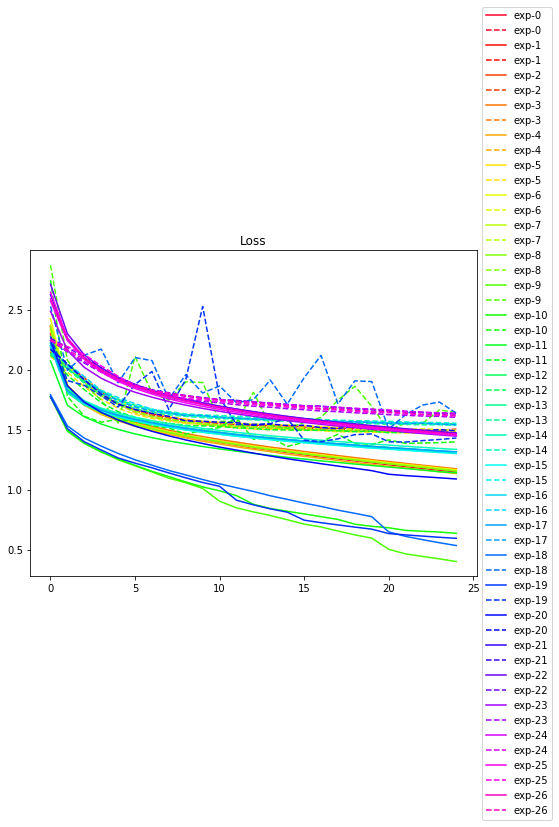

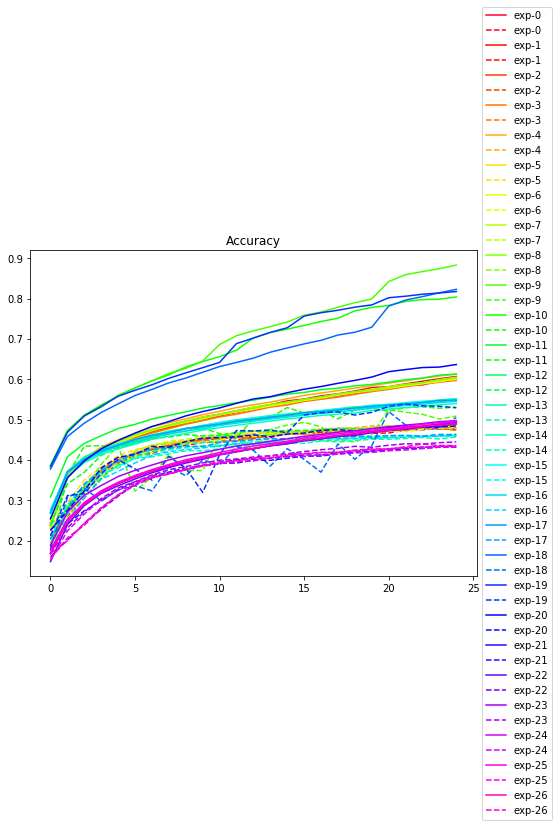

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()